In [3]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random
random.seed(100)

In [4]:
def f(x):
    return 3*x**2 -4*x +5

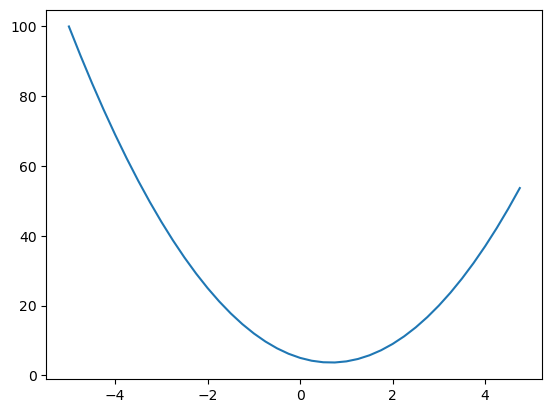

In [6]:
xp = np.arange(-5,5,0.25)
yp = f(xp)
plt.plot(xp,yp)

In [19]:
class Value:
    def __init__(self, data, _children= (), _op= '', label= '' ):
        self.data = data
        self.grad = 0.0  #grad is derivative of L(output) wrt self 
        self._prev = set(_children)
        self._backward = lambda : None
        self._op= _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"  

    def __add__(self,b):

        b = b if isinstance(b, Value) else Value(b)
        out = Value(self.data+b.data, (self, b), _op='+')
        def _backward():
          self.grad += 1.0 * out.grad
          b.grad += 1.0 * out.grad
        out._backward = _backward
        return out    

    def __sub__(self, b):
        b = b if isinstance(b, Value) else Value(b)
        return self + (-b)
        
    def __radd__(self,other):
        return self + other

    def __neg__(self):
        return self * -1
    
    def __mul__(self,b):
        b = b if isinstance(b, Value) else Value(b)
        out = Value(self.data*b.data, (self, b), _op='*')
        def _backward():
          self.grad += b.data * out.grad
          b.grad += self.data* out.grad
        out._backward = _backward
        return out    

    def __rmul__(self,b):
        return self*b

    def __truediv__(self, b):
        return self * b**-1

    def exp(self):
        o = Value(math.exp(self.data), (self, ), 'exp')
        def _backward():
            self.grad = o.data * o.grad
        o._backward = _backward
        return o

    def __pow__(self, b):
        assert isinstance(b, (int, float)) , 'Only int and float supported'
        o = Value(self.data**b, (self, ), 'pow')

        def _backward():
            self.grad = o.grad * (b*(self.data**(b-1)))
        o._backward = _backward
        return o
        
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        o = Value(t, (self,), 'tanh')
        def _backward():
            self.grad  += (1-t**2)*o.grad
        o._backward = _backward
        return o

    def backward(self):
    
        topo = []
        visited = set()
        def build_topo(v):
          if v not in visited:
            visited.add(v)
            for child in v._prev:
              build_topo(child)
            topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
          node._backward()


In [5]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


In [6]:
a = Value(2.0, label = 'a')
b = Value(3.2, label = 'b')
e = a*b ; e.label = 'e'
f = a+b; f.label = 'f'
d = f  + e ; d.label = 'd'
c = Value(1.1, label = 'c')
out = d * c ; out.label = 'out'

In [169]:
a = Value(2)
b = Value(3)
a-b

Value(data=-1)

In [7]:
out.backward()

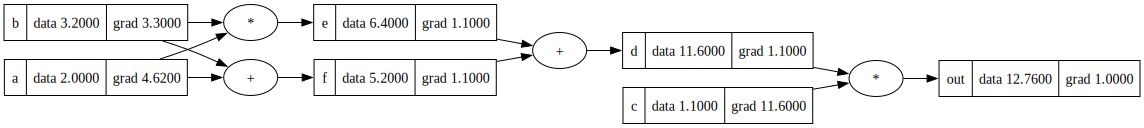

In [8]:
draw_dot(out)

In [9]:
out.grad = 1.0
c.grad = 11.6
d.grad = 1.1
e.grad = 1.1
f.grad = 1.1
a.grad = 1.1
b.grad  = 1.1

In [10]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'


In [11]:
o.backward()

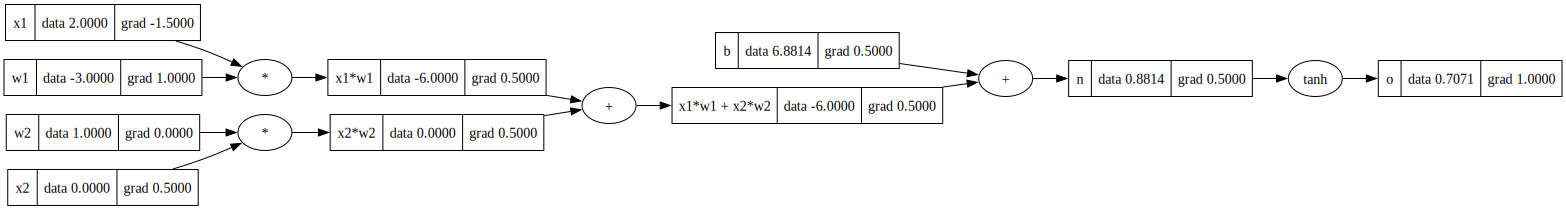

In [12]:
draw_dot(o)

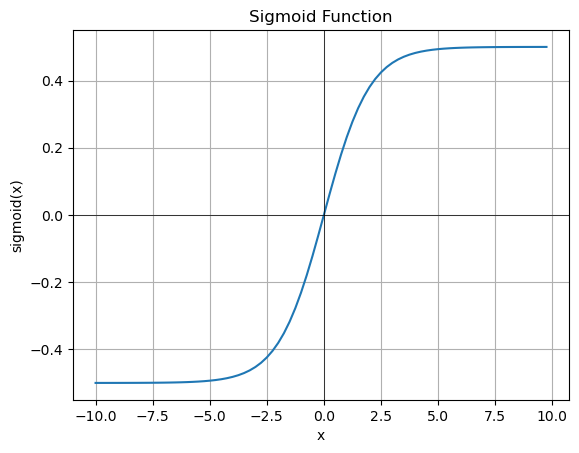

In [13]:
def sigmoid(x):
    return 1/(1+math.exp(-x)) - 0.5

xp = np.arange(-10,10,0.25)
yp = np.array([sigmoid(x) for x in xp])
plt.plot(xp,yp)
plt.title("Sigmoid Function")
plt.xlabel("x")
plt.ylabel("sigmoid(x)")
plt.grid(True)
plt.axhline(0, color='black', lw=0.5)
plt.axvline(0, color='black', lw=0.5)
plt.show()

In [14]:
class Neuron:

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        o = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        o = o.tanh()
        return o 
    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin , nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        out = [p(x) for p in self.neurons]
        return out[0] if len(out) == 1 else out
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters]

class MLP: #multi layer perceptron
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        p = []
        for layer in self.layers:
            p.extend(layer.parameters)
        return p


In [43]:
random.seed(100)
n = Neuron(2)
x = [2,3]
l = Layer(2, 4)
m = MLP(3, [3,4,2,1])

In [16]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [17]:
ypred = [n(x) for x in xs]
loss = [(a.data-b)**2 for a, b in zip(ypred, ys)]
print('ys:', ys)
print('ypreds', ypred)


ys: [1.0, -1.0, -1.0, 1.0]
ypreds [Value(data=-0.8164890829235918), Value(data=-0.904107576020701), Value(data=0.09678694124813186), Value(data=-0.25171208254159577)]


In [20]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss.backward()

In [31]:
print('data', m.layers[0].neurons[0].w[0].data)
print('grad', m.layers[0].neurons[0].w[0].grad)

data 0.5360362974901609
grad 0.0


In [48]:
m(x).grad

0.0

In [46]:
m(x).backward()

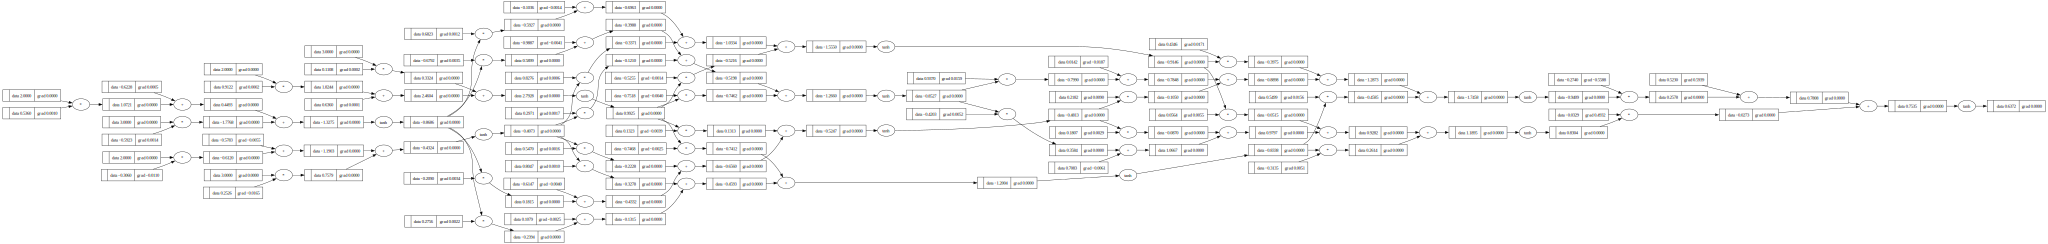

In [47]:
draw_dot(m(x))